# Traditional Machine Learning Forecasting Methods

The previous notebooks covered traditional statistical methods, each having its own pros and cons.
The next step is to try traditional machine learning methods.

Machine learning methods allow for a variety of models to be used for forecasting. In particular, they allow for complex non-linear relationships to be modeed. Also, ML models allow for different forecasting horizons, such as 1-step, multi-step, and multi-output. We can also do ML forecasting for the actual signal as well as the differenced one (typically needed for signals that have a trend)

Below we go over a number of machine learning models and how to use them for forecasting. One major part in this exercise is the data processing part required to create the datasets for each of the three types of forecasting

In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn import linear_model

from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_percentage_error

import statsmodels.api as sm
import pmdarima as pm
import warnings
warnings.filterwarnings('ignore')

In [11]:
df=pd.read_excel('Traffic.xlsx')

df['Start Time'] = pd.to_datetime(df['Start Time'])
df.set_index('Start Time',drop=False,inplace=True)
df['DL RBLER (%)']=df['DL RBLER (%)'].replace('NIL',np.nan)
df['DL RBLER (%)']=df['DL RBLER (%)'].astype(float)
df['DL RBLER (%)'].fillna(df['DL RBLER (%)'].median(),inplace=True)
df['DL user tput']=df['L.Thrp.bits.DL.QCI.9 (bit)']/(df['L.Thrp.Time.DL.QCI.9 (ms)']*1000)
df['DL cell tput']=df['L.Thrp.bits.DL (bit)']/(df['L.Thrp.Time.Cell.DL (s)']*1000000)

df['DL user tput']=df['DL user tput'].replace(np.nan,0)
df['DL cell tput']=df['DL cell tput'].replace(np.nan,0)

df_filter=df[df['Cell']=='Local cell identity=2, Cell Name=eNB_3401-2']

df_filter=df_filter.drop('Cell',axis=1)

df_filter.index.freq='15T'
df_filter.index

DatetimeIndex(['2013-08-28 00:00:00', '2013-08-28 00:15:00',
               '2013-08-28 00:30:00', '2013-08-28 00:45:00',
               '2013-08-28 01:00:00', '2013-08-28 01:15:00',
               '2013-08-28 01:30:00', '2013-08-28 01:45:00',
               '2013-08-28 02:00:00', '2013-08-28 02:15:00',
               ...
               '2013-09-04 21:30:00', '2013-09-04 21:45:00',
               '2013-09-04 22:00:00', '2013-09-04 22:15:00',
               '2013-09-04 22:30:00', '2013-09-04 22:45:00',
               '2013-09-04 23:00:00', '2013-09-04 23:15:00',
               '2013-09-04 23:30:00', '2013-09-04 23:45:00'],
              dtype='datetime64[ns]', name='Start Time', length=768, freq='15T')

Up to here is similar to what we did for ARIMA and ETS methods.

Now, we will add a differenced data column to our dataset. We will use it when we get to forecasting with differencing

In [213]:
df_filter['1st_diff_tput']=df_filter['DL user tput'].diff()

Next we create the dataset for the 1-step forecasting. 1-step forecasting is usefull when we need to get forecasts one step ahead only. In our data that corresponds to knowing the DL user tput 15 minutes ahead. This could be useful in cases where the content will be customised based on the users download speed.

The below workflow can be put in a function, or even better, as part of a class in OOP

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.27196364278393076
multistep_predictions RMSE: 0.43745968399970747
multioutput RMSE: 0.4257699589233564


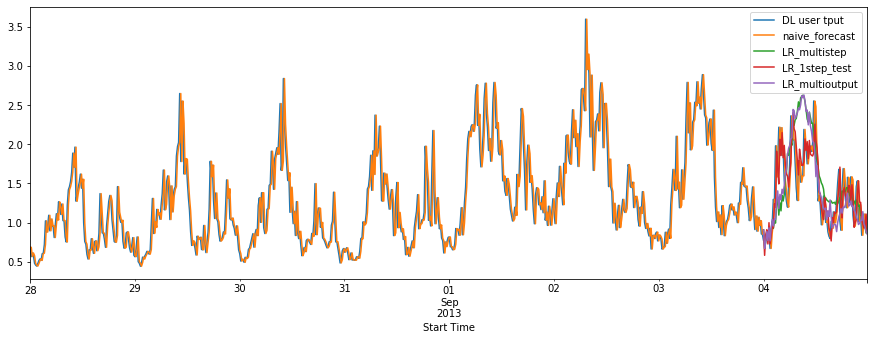

In [575]:
#Create a train and test sets. The test set is one full day as before (96 samples)

Samtest=96
train=df_filter.iloc[:-Samtest]
test=df_filter.iloc[-Samtest:]

#Put the user tput column in a numpy array. Not really required but working with numpy arrays is usually easier

series=df_filter['DL user tput'].to_numpy()

#T is size of our inputs, which in our case is the previous 96 data points.
#X and Y are empty lists and are placeholders for our input and output

T=96
X=[]
Y=[]

# Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
#append the X and Y lists

for t in range(len(series)-T):
    x=series[t:t+T]
    X.append(x)
    y=series[t+T]
    Y.append(y)

#put back X and Y into arrays and reshape X as T inputs
X=np.array(X).reshape(-1,T)
Y=np.array(Y)


#create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


#Create and index for train and test from the original dataframe.
#Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

train_idx=df_filter.index <= train.index[-1]
test_idx=~train_idx
train_idx[:T]=False

#Train the ML model...Linear Regression is used as an example

lr=LinearRegression()
lr.fit(Xtrain,Ytrain)

#generate naive forecast

df_filter['naive_forecast']=df_filter['DL user tput'].shift(1)
df_filter['naive_forecast'][0]=df_filter['naive_forecast'][1]

#generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
# the train and test indicies
df_filter.loc[train_idx,'LR_1step_train']=lr.predict(Xtrain)
df_filter.loc[test_idx,'LR_1step_test']=lr.predict(Xtest)


#Multi-step predictions: Create an empty list as a placeholder for the multi-step results
#Set the first datapoint in test as the last known sample
#generate predictions by using a while loop (as long as the muilt-step results list is 
#less than the Samtest forecast horizon) and append every output to the list
#Update the last known sample by setting it to the predicted value and repeat up to Samtest times


multistep_predictions=[]

last_x=Xtest[0]

while len(multistep_predictions) < Samtest:
    p=lr.predict(last_x.reshape(1,-1))[0]
    
    multistep_predictions.append(p)
    
    last_x=np.roll(last_x,-1)
    last_x[-1]=p
    
#Update the original dataframe with the multi-step forecast results
df_filter.loc[test_idx,'LR_multistep']=multistep_predictions


#Multi-output predictions: In the multi-output case the input samples are the same but the output
#is a vector of values rather than a single value. In this the input is Tx (T as before)
#but the output is Ty and is set to the full length of the test horizon Samtest

Tx=T
Ty=Samtest
X=[]
Y=[]

#Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

for t in range(len(series)-Tx-Ty+1):
    x=series[t:t+Tx]
    X.append(x)
    y=series[t+Tx:t+Tx+Ty]
    Y.append(y)

#X and Y are put back into array form and reshaped
X=np.array(X).reshape(-1,Tx)
Y=np.array(Y).reshape(-1,Ty)


#A new set of train and test sets are created for the multi-output case from X and Y
Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
Xtest_m,Ytest_m=X[-1:],Y[-1:]

#ML model trained again on the new dataset
lr=LinearRegression()
lr.fit(Xtrain_m,Ytrain_m)

#multi-output predictions generated and placed into the origial dataframe
df_filter.loc[test_idx,'LR_multioutput']=lr.predict(Xtest_m).flatten()

#Plot the output for the 1-step,multi-step, and multi-output

cols=['DL user tput','naive_forecast','LR_multistep','LR_1step_test','LR_multioutput']
df_filter[cols].plot(figsize=(15,5))

RMSE0=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,'naive_forecast']))

print("naive forecast RMSE:",RMSE0)

RMSE1=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,'LR_1step_test']))

print("1-step_predictions RMSE:",RMSE1)

RMSE2=np.sqrt(mean_squared_error(Ytest,multistep_predictions))

print("multistep_predictions RMSE:",RMSE2)

RMSE3=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,'LR_multioutput']))

print("multioutput RMSE:",RMSE3)

The above output shows the RMSE for each method along with the plot. We can see that the 1-step forecast does worse than the naive forecast, which implies that if the goal is to forecast one step ahead then it is better just to use the naive forecast.
For the case of forecasting one day ahead, the multi-output forecast outperforms the multi-step forecast.

The above steps ca be put into a function and then repeated for different types of models. Below is a function that takes the type of model and name as an input and give the RMSE and plot as outputs.

In [19]:
def ML_forecast(model,name):
    #Create a train and test sets. The test set is one full day as before (96 samples)

    Samtest=96
    train=df_filter.iloc[:-Samtest]
    test=df_filter.iloc[-Samtest:]

    #Put the user tput column in a numpy array. Not really required but working with numpy arrays is usually easier

    series=df_filter['DL user tput'].to_numpy()

    #T is size of our inputs, which in our case is the previous 96 data points.
    #X and Y are empty lists and are placeholders for our input and output

    T=96
    X=[]
    Y=[]

    # Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
    #append the X and Y lists

    for t in range(len(series)-T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)

    #put back X and Y into arrays and reshape X as T inputs
    X=np.array(X).reshape(-1,T)
    Y=np.array(Y)


    #create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
    Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
    Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


    #Create and index for train and test from the original dataframe.
    #Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

    train_idx=df_filter.index <= train.index[-1]
    test_idx=~train_idx
    train_idx[:T]=False

    #Train the ML model...Linear Regression is used as an example

    lr=model
    lr.fit(Xtrain,Ytrain)
    
    #generate naive forecasts
    
    df_filter['naive_forecast']=df_filter['DL user tput'].shift(1)
    df_filter['naive_forecast'][0]=df_filter['naive_forecast'][1]
    

    #generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
    # the train and test indicies
    df_filter.loc[train_idx,f'{name}_1step_train']=lr.predict(Xtrain)
    df_filter.loc[test_idx,f'{name}_1step_test']=lr.predict(Xtest)


    #Multi-step predictions: Create an empty list as a placeholder for the multi-step results
    #Set the first datapoint in test as the last known sample
    #generate predictions by using a while loop (as long as the muilt-step results list is 
    #less than the Samtest forecast horizon) and append every output to the list
    #Update the last known sample by setting it to the predicted value and repeat up to Samtest times


    multistep_predictions=[]

    last_x=Xtest[0]

    while len(multistep_predictions) < Samtest:
        p=lr.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x=np.roll(last_x,-1)
        last_x[-1]=p

    #Update the original dataframe with the multi-step forecast results
    df_filter.loc[test_idx,f'{name}_multistep']=multistep_predictions


    #Multi-output predictions: In the multi-output case the input samples are the same but the output
    #is a vector of values rather than a single value. In this the input is Tx (T as before)
    #but the output is Ty and is set to the full length of the test horizon Samtest

    Tx=T
    Ty=Samtest
    X=[]
    Y=[]

    #Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

    for t in range(len(series)-Tx-Ty+1):
        x=series[t:t+Tx]
        X.append(x)
        y=series[t+Tx:t+Tx+Ty]
        Y.append(y)

    #X and Y are put back into array form and reshaped
    X=np.array(X).reshape(-1,Tx)
    Y=np.array(Y).reshape(-1,Ty)


    #A new set of train and test sets are created for the multi-output case from X and Y
    Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
    Xtest_m,Ytest_m=X[-1:],Y[-1:]

    #ML model trained again on the new dataset
    lr=model
    lr.fit(Xtrain_m,Ytrain_m)

    #multi-output predictions generated and placed into the origial dataframe
    df_filter.loc[test_idx,f'{name}_multioutput']=lr.predict(Xtest_m).flatten()

    #Plot the output for the 1-step,multi-step, and multi-output

    cols=['DL user tput','naive_forecast',f'{name}_multistep',f'{name}_1step_test',f'{name}_multioutput']
    df_filter[cols].plot(figsize=(15,5))


    RMSE0=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,'naive_forecast']))

    print("naive forecast RMSE:",RMSE0)

    RMSE1=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,f'{name}_1step_test']))

    print("1-step_predictions RMSE:",RMSE1)

    RMSE2=np.sqrt(mean_squared_error(Ytest,multistep_predictions))

    print("multistep_predictions RMSE:",RMSE2)

    RMSE3=np.sqrt(mean_squared_error(Ytest,df_filter.loc[test_idx,f'{name}_multioutput']))

    print("multioutput RMSE:",RMSE3)

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.25480529196986423
multistep_predictions RMSE: 0.8391131554651645
multioutput RMSE: 0.2974301039526072


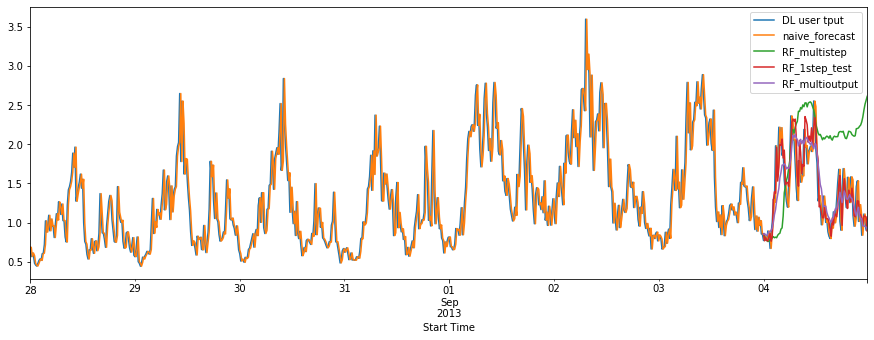

In [581]:
ML_forecast(RandomForestRegressor(),"RF")

Above the Random forest regressor was tried. A s seen form the RMSE the 1-step forecast outperforms the naive forecast. In this case it is better to use the model to forecast one step ahead.
In addition, the multi-output forecast outperforms the multi-step forecast, as well as all forecasts for the linear regression model.

Other models could be tried with this workflow. Some hyper parameter tuning could be done as well as walk-forward validation.

### Machine Learning Forecasting with Differencing

Differencing is helpful for signals that have a clear trend in them (non-stationary in general). The above workflow could be modified to account for the differencing step then the undifferencing at the end. Let's go over it again and make the modifications

In [603]:
def ML_forecast_diff(model,name):
    
    #create a differenced column
    df_filter['1st_diff_tput']=df_filter['DL user tput'].diff()
    
    #Create a train and test sets. The test set is one full day as before (96 samples)

    Samtest=96
    train=df_filter.iloc[:-Samtest]
    test=df_filter.iloc[-Samtest:]

    #Put the 1st difference column instead of the DL user tput in a numpy array

    series=df_filter['1st_diff_tput'].to_numpy()[1:]

    #T is size of our inputs, which in our case is the previous 96 data points.
    #X and Y are empty lists and are placeholders for our input and output

    T=96
    X=[]
    Y=[]

    # Run a for loop where you store each set of 96 inputs in X and the next datapoint as the output in Y. Each time we
    #append the X and Y lists

    for t in range(len(series)-T):
        x=series[t:t+T]
        X.append(x)
        y=series[t+T]
        Y.append(y)

    #put back X and Y into arrays and reshape X as T inputs
    X=np.array(X).reshape(-1,T)
    Y=np.array(Y)

    

    #create new train and test sets based on our reshaped datasets X and Y. Samtest is used as our cutoff between train and test
    Xtrain, Ytrain=X[:-Samtest], Y[:-Samtest]
    Xtest, Ytest=X[-Samtest:], Y[-Samtest:]


    #Create and index for train and test from the original dataframe.
    #Make sure to remove the first 96 datapoints from the train set as they are only used as part of the input data

    train_idx=df_filter.index <= train.index[-1]
    test_idx=~train_idx
    
    #set the train_index as False for T+1 instead of T as we have differenced values
    train_idx[:T+1]=False

    #Calculate the previous values required to make the predictions for the 1-step forecast
    df_filter['Shift_tput']=df_filter['DL user tput'].shift(1)
    prev=df_filter['Shift_tput']

    #get the last train data point required for multi-step and multi-output predictions
    last_train=train.iloc[-1]['DL user tput']
    
    #Train the ML model...

    lr=model
    lr.fit(Xtrain,Ytrain)
    
    #generate naive forecasts
    
    df_filter['naive_forecast']=df_filter['DL user tput'].shift(1)
    df_filter['naive_forecast'][0]=df_filter['naive_forecast'][1]
    

    #generate 1-step predictions for both train and test data and store the output back in the original dataframe based on
    # the train and test indicies. 1-step predictions are now based on the previous value + the predicted difference

    df_filter.loc[train_idx,f'{name}_1step_train']=prev[train_idx]+model.predict(Xtrain)
    df_filter.loc[test_idx,f'{name}_1step_test']=prev[test_idx]+model.predict(Xtest)


    #Multi-step predictions: Create an empty list as a placeholder for the multi-step results
    #Set the first datapoint in test as the last known sample
    #generate predictions by using a while loop (as long as the muilt-step results list is 
    #less than the Samtest forecast horizon) and append every output to the list
    #Update the last known sample by setting it to the predicted value and repeat up to Samtest times    


    multistep_predictions=[]

    last_x=Xtest[0]

    while len(multistep_predictions) < Samtest:
        p=lr.predict(last_x.reshape(1,-1))[0]

        multistep_predictions.append(p)

        last_x=np.roll(last_x,-1)
        last_x[-1]=p

    #Update the original dataframe with the multi-step forecast results. The multi-step predictions are 
    #now the last train value + the accumulated predicted difference
    
    df_filter.loc[test_idx,f'{name}_multistep']=last_train+np.cumsum(multistep_predictions)


    #Multi-output predictions: In the multi-output case the input samples are the same but the output
    #is a vector of values rather than a single value. In this the input is Tx (T as before)
    #but the output is Ty and is set to the full length of the test horizon Samtest
    

    Tx=T
    Ty=Samtest
    X=[]
    Y=[]

    #Similar for loop as before but Y now is a ange of value defined by Tx and Ty and not Tx only

    for t in range(len(series)-Tx-Ty+1):
        x=series[t:t+Tx]
        X.append(x)
        y=series[t+Tx:t+Tx+Ty]
        Y.append(y)

    #X and Y are put back into array form and reshaped
    X=np.array(X).reshape(-1,Tx)
    Y=np.array(Y).reshape(-1,Ty)

    #A new set of train and test sets are created for the multi-output case from X and Y
    Xtrain_m,Ytrain_m=X[:-1],Y[:-1]
    Xtest_m,Ytest_m=X[-1:],Y[-1:]

    #ML model trained again on the new dataset
    lr=model
    lr.fit(Xtrain_m,Ytrain_m)

    #multi-output predictions generated and placed into the origial dataframe. The multi-output predictions are again 
    #the last train value + the accumulated predicted difference
    df_filter.loc[test_idx,f'{name}_multioutput']= last_train+np.cumsum(model.predict(Xtest_m).flatten())

    #Plot the output for the 1-step,multi-step, and multi-output

    cols=['DL user tput','naive_forecast',f'{name}_multistep',f'{name}_1step_test',f'{name}_multioutput']
    df_filter[cols].plot(figsize=(15,5))

    test_tput=df_filter.iloc[-Samtest:]['DL user tput']

    RMSE0=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,'naive_forecast']))

    print("naive forecast RMSE:",RMSE0)

    RMSE1=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_1step_test']))

    print("1-step_predictions RMSE:",RMSE1)

    RMSE2=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multistep']))

    print("multistep_predictions RMSE:",RMSE2)

    RMSE3=np.sqrt(mean_squared_error(test_tput,df_filter.loc[test_idx,f'{name}_multioutput']))

    print("multioutput RMSE:",RMSE3)

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.27324475229908196
multistep_predictions RMSE: 0.4560225029667489
multioutput RMSE: 0.44955512025899047


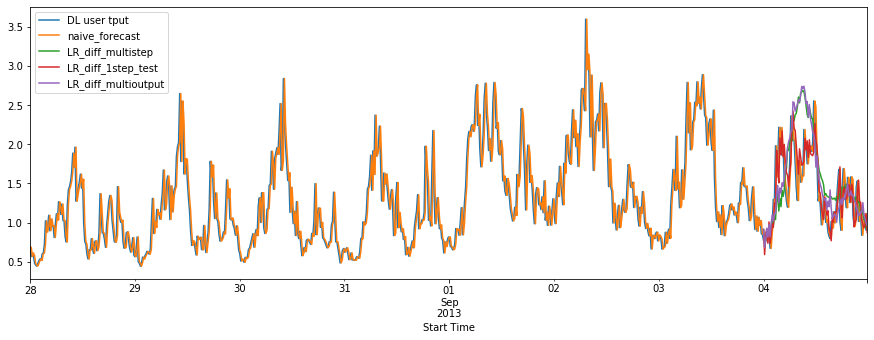

In [604]:
ML_forecast_diff(LinearRegression(),"LR_diff")

naive forecast RMSE: 0.2610105386505019
1-step_predictions RMSE: 0.2558166021922972
multistep_predictions RMSE: 1.9839420663282763
multioutput RMSE: 0.5955136543506072


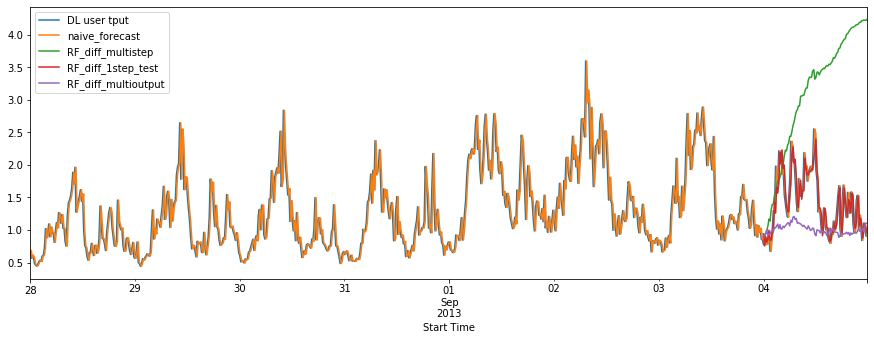

In [605]:
ML_forecast_diff(RandomForestRegressor(),"RF_diff")

As seen from above, the best performing model for the 1-step forecast is the Random forest with no differencing.
The abest model for the 96 sample horizon (one day ahead) is the random forest without differencing also.

The above workflows can be combined with frameworks for hyper-parameter tuning and walk-forward validation for better results